In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
cat_columns = df.select_dtypes(include="object").columns.tolist()
num_columns = df.select_dtypes(exclude="object").columns.tolist()
num_columns.remove("converted")

In [7]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
df[cat_columns] = df[cat_columns].fillna('NA')
df[num_columns] = df[num_columns].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train,df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train,df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [11]:
for feature in num_columns:
    print(feature,":",roc_auc_score(y_train, df_train[feature]))

number_of_courses_viewed : 0.7635680590007088
annual_income : 0.5519578313253012
interaction_count : 0.738270176293409
lead_score : 0.6144993577250176


In [17]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_columns + num_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [18]:
val_dict = df_val[cat_columns + num_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict(X_val)

In [19]:
round(roc_auc_score(y_val, y_pred),3)

0.648

In [15]:
thresholds = np.linspace(0,1, num=101)

In [45]:
precision = []
recall = []
f1 = []
for t in thresholds:
    y_pred = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred >= t)
    r = recall_score(y_val, churn_decision)
    recall.append(r)
    p = precision_score(y_val, churn_decision)
    precision.append(p)
    f = (2*p*r)/(p+r+1e-10)
    f1.append(f)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


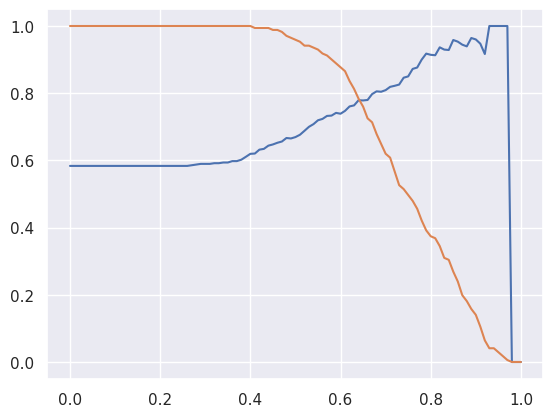

In [46]:
plt.plot(thresholds, precision)
plt.plot(thresholds, recall)

In [53]:
thresholds[pd.Series(f1).idxmax()]

np.float64(0.5700000000000001)

In [63]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv = DictVectorizer(sparse=False)

        train_dict = df_train[cat_columns + num_columns].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)   
        model.fit(X_train, y_train)

        val_dict = df_val[cat_columns + num_columns].to_dict(orient='records')
        X_val = dv.transform(val_dict)
        
        y_pred = model.predict(X_val)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.664 +- 0.025
C=0.001 0.664 +- 0.025
C=1 0.664 +- 0.025
